In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (26, 8)

In [2]:
from pyspark.sql import SparkSession, functions as F

In [3]:
spark = SparkSession \
        .builder \
        .master('local[*]') \
        .appName("for recommender") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.maxResultSize", "3g") \
        .getOrCreate()

In [4]:
author_tag_nums = spark.read.parquet('./author_tag_articlenum.parquet/')  # Path to the given parquet
denormalized_tag_author = spark.read.parquet('./denormalized_tag_authors.parquet/')  # Path to the given parquet

In [33]:
def get_recommendations(author_id: int):
    tags = author_tag_nums.where(F.col('id_author') == author_id).select('tags').toPandas()['tags'].tolist()
    local_authors = denormalized_tag_author \
                        .where(F.col('tags').isin(tags)) \
                        .select(F.slice(F.col('author_ids'), 1, 10).alias('author_ids')) \
                        .select(F.explode('author_ids'))
    return local_authors \
                .where(F.col('col') != author_id) \
                .distinct() \
                .limit(10) \
                .toPandas() \
                .rename(columns={'col': 'id_author'})

### Metric: 
$$
Jaccard(X, Recs(X)) = \frac{|X \wedge Recs(X)|}{|X \lor Recs(X)|} = \frac{\sum_{T \in Recs(X)} |tags(X) \wedge tags(T)|}{\sum_{T \in Recs(X)} |tags(X) \lor tags(T)|}
$$

In [76]:
recs = get_recommendations(469894)

In [77]:
recs

,id_author
0,530113
1,521932
2,1025474
3,542855
4,428925
5,952532
6,998320
7,425451
8,421139
9,428802


In [7]:
pd_df = author_tag_nums.where(F.col('id_author').isin(recs['id_author'].tolist())).dropDuplicates(['id_author']).toPandas()

In [8]:
recs.merge(pd_df, on='id_author')

,id_author,tags,num_articles
0,530113,angle,150
1,521932,client,160
2,1025474,agents,108
3,542855,document,59
4,428925,alignment,81
5,952532,bits,190
6,998320,check,86
7,425451,activities,80
8,421139,architectures,91
9,428802,bandwidth,122


In [8]:
df = spark.read.parquet('./test.parquet/')
# test_auth = df.select(F.explode('authors.name'))

In [9]:
fin_articles = spark.read.parquet('./fin_articles.parquet/')

In [10]:
fin_articles.limit(5).to_pandas_on_spark()

/home/ippk93/anaconda3/envs/made_1/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,id,old_id,title,year,n_citation,article_len,lang,issn,keywords,isbn,abstract,has_doi,fos,id_venue
0,6,53e997ddb7602d9701fd7420,Minimum sum multicoloring on the edges of trees,2006.0,15.0,17,en,Theoretical Computer Science,"finish time, main result, integer demand, poly...",,The edge multicoloring problem is that given a...,False,"Disjoint sets, Discrete mathematics, Graph, Po...",29777
1,9,53e997e4b7602d9701fdad4b,Research on development and application of OWL...,2013.0,4.0,5,en,0895-7177,"Ontology query, Middleware, OWL ontology, Onto...",,This paper introduces an OWL ontology search m...,False,"Ontology (information science), Upper ontology...",6062
2,27,53e997f1b7602d9701ff223f,Automated Profile Mapping,2006.0,0.0,6,en,,"different profile format, increase profile int...",0-88986-560-4,Profiles have a wide range of applications (e....,True,"Interoperability, Personalization, Database, C...",15115
3,51,53e99804b7602d97020164c0,Forward image mapping,1999.0,37.0,8,en,,"memory bandwidth, hardware, gouraud shading, a...",0-7803-5897-X,We present a new forward image mapping algorit...,False,"Artificial intelligence, Scanline rendering, S...",10254
4,56,53e99808b7602d970201bd20,Computational modeling systems,1995.0,39.0,27,en,Information Systems,"data model, computational modeling systems, sc...",,A computational modeling system (CMS) provides...,False,"Modeling language, Scientific modelling, Progr...",31677


In [11]:
auth_art = spark.read.parquet('./fin_auth_article.parquet/')

In [12]:
test_ids = df.select('old_id')
test_ids = test_ids.join(fin_articles, fin_articles.old_id == test_ids.old_id).select('id')

In [13]:
test_ids.show()

+----+
|  id|
+----+
|   9|
| 215|
| 912|
| 920|
|1149|
|1150|
|1395|
|1739|
|1858|
|2170|
|2297|
|2818|
|2879|
|3481|
|3541|
|3733|
|3779|
|4251|
|4632|
|4863|
+----+
only showing top 20 rows



In [14]:
auth_art.show()

+---------+----------+
|id_author|id_article|
+---------+----------+
|        1|    867327|
|        2|    121653|
|        3|    825184|
|        3|    842284|
|        3|   1001088|
|        4|    370529|
|        5|    598949|
|        6|    281983|
|        7|    116302|
|        8|     23992|
|        9|    733026|
|       10|    127746|
|       11|    428531|
|       11|    538599|
|       12|    743830|
|       13|    971539|
|       14|     94588|
|       15|    719499|
|       16|    795106|
|       17|    727383|
+---------+----------+
only showing top 20 rows



In [15]:
auth_art_test = auth_art.join(test_ids, auth_art.id_article == test_ids.id).select('id_author', 'id_article')

In [16]:
auth_art_test.show()

+---------+----------+
|id_author|id_article|
+---------+----------+
|     1489|    409092|
|     1543|    409092|
|     3142|    460123|
|     4615|    743061|
|     4624|     11033|
|     5845|    839814|
|     6503|    611726|
|     6730|    450801|
|     7014|    108221|
|     8651|    716590|
|     9229|    284829|
|    10669|    597388|
|    13063|    829115|
|    15045|    155510|
|    15047|    627610|
|    15435|    171723|
|    16945|    564376|
|    17449|    463850|
|    18834|    250934|
|    20539|    835106|
+---------+----------+
only showing top 20 rows



In [17]:
authors_test = auth_art_test.select('id_author')

In [18]:
pd_test = authors_test.to_pandas_on_spark()

/home/ippk93/anaconda3/envs/made_1/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [19]:
pd_test.head()

,id_author
0,1489
1,1543
2,3142
3,4615
4,4624


In [20]:
temp_ids = pd_test['id_author'].to_numpy()

/home/ippk93/anaconda3/envs/made_1/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [21]:
author_tag_pd = author_tag_nums.select('id_author', 'tags').toPandas()

In [22]:
author_tag_pd.head()

,id_author,tags
0,53,bit
1,53,frame
2,53,encoding
3,53,location
4,53,mode


In [43]:
jaccard_measures = []

In [ ]:
for id_ in tqdm(temp_ids):
    int_id = int(id_)
    res = get_recommendations(int_id)

    tags_author = set(author_tag_pd[author_tag_pd['id_author'] == int_id]['tags'])
    
    jac_num = 0
    jac_denom = 0
    for author_id in res['id_author']:
        tags_coauthor = set(author_tag_pd[author_tag_pd['id_author'] == author_id]['tags'])
        
        jac_num += len(tags_author.intersection(tags_coauthor))
        jac_denom += len(tags_author.union(tags_coauthor))
        
    if jac_num != jac_denom:
        jaccard_measures.append(jac_num / jac_denom)

In [57]:
jac_numpy = np.array(jaccard_measures)

In [61]:
print("Median:", np.median(jac_numpy))
print("Mean:", np.mean(jac_numpy))

Median: 0.045271049596309114
Mean: 0.05732289293591393


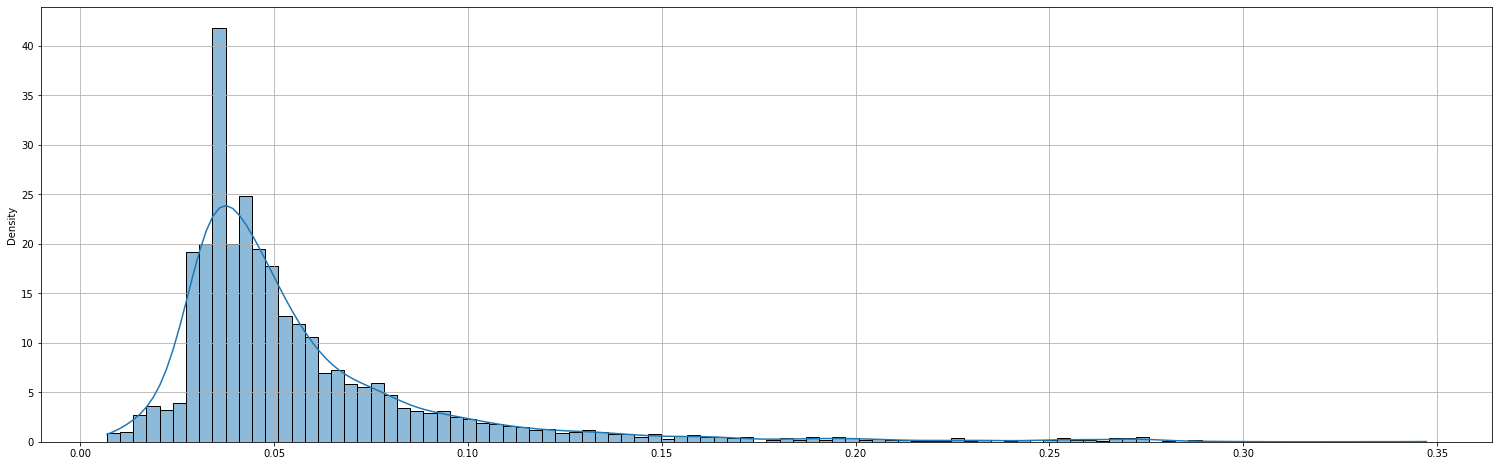

In [96]:
sns.histplot(jaccard_measures, kde=True, common_bins=True, stat='density', bins=100)
plt.grid()

In [90]:
jaccard_measures_random = []

In [ ]:
for id_ in tqdm(temp_ids):
    int_id = int(id_)
    
    tags_author = set(author_tag_pd[author_tag_pd['id_author'] == int_id]['tags'])

    jac_num = 0
    jac_denom = 0
    for author_id in author_tag_pd['id_author'].sample(n=10):
        tags_coauthor = set(author_tag_pd[author_tag_pd['id_author'] == author_id]['tags'])
        
        jac_num += len(tags_author.intersection(tags_coauthor))
        jac_denom += len(tags_author.union(tags_coauthor))
        
    if jac_num != jac_denom:
        jaccard_measures_random.append(jac_num / jac_denom)

In [92]:
print("Median:", np.median(np.array(jaccard_measures_random)))
print("Mean:", np.mean(np.array(jaccard_measures_random)))

Median: 0.0
Mean: 0.030833509906638825


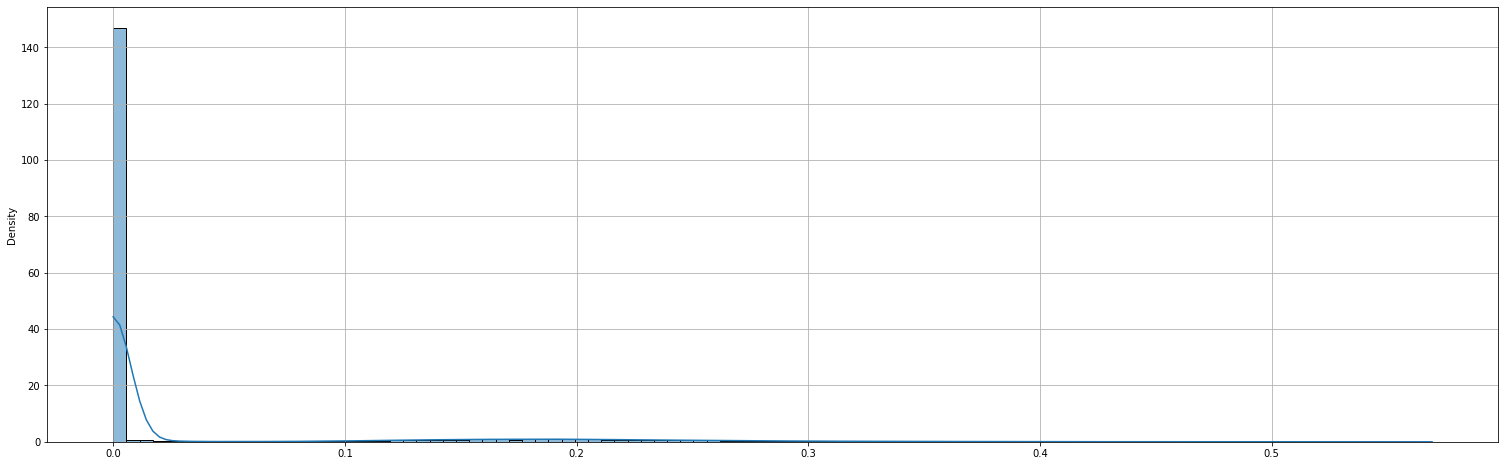

In [97]:
sns.histplot(jaccard_measures_random, kde=True, common_bins=True, stat='density', bins=100)
plt.grid()

## Conclusion

Наша модель существенно превосходит бейзлайн (у которого медиана распределения метрики находится в 0). 

Из смысла медианы - не менее половины предсказаний у бейзлайна дают метрику == 0 (против 0.045 у нашей модели).